In [1]:
from __future__ import absolute_import, division, print_function

import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.autograd import Variable

import os
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt

In [2]:
# file params
DATA_PATH = "tang.npz"
MODEL_SAVE_PATH = "./model"

# model params
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_SIZE = 512
NUM_LAYERS = 2

# train params
EPOCH = 48
LEARNING_RATE = 0.001

In [3]:
# prepare data
def load_data(data_path):
    if os.path.exists(data_path):
        datas = np.load(data_path, allow_pickle=True)
        data = datas['data']
        ix2word = datas['ix2word'].item()
        word2ix = datas['word2ix'].item()
        print('[INFO]: Dataset is loaded successfully')
        return data, word2ix, ix2word

    else:
        print('[ERROR]: No such file named', datapath)
        exit(-1)

In [4]:
# take a look at a poem randomly
def visualize(data, row):
    example = str()
    for col in range(data.shape[1]):
        example += ix2word[data[row,col]]  
    print(example)

In [5]:
# create the module
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=self.hidden_dim,
                            num_layers=NUM_LAYERS, batch_first=False)
        self.linear = nn.Linear(self.hidden_dim, vocab_size)
    
    def forward(self, input_, hidden=None):
        seq_len, batch_size = input_.size()
        if hidden is None:
            h_0 = input_.data.new(NUM_LAYERS, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input_.data.new(NUM_LAYERS, batch_size, self.hidden_dim).fill_(0).float()
            h_0, c_0 = Variable(h_0), Variable(c_0)
        else:
            h_0, c_0 = hidden
        embeds = self.embeddings(input_)
        output, hidden = self.lstm(embeds, (h_0, c_0))
        output = self.linear(output.reshape(seq_len * batch_size, -1))
        return output, hidden       


In [6]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    running_loss = 0.0
    step = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        data = data.long().transpose(0,1).contiguous().to(device)
        optimizer.zero_grad()
        input_data, target = Variable(data[:-1, :]), Variable(data[1:, :])
        output, _ = model(input_data)
        loss = criterion(output, target.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step += 1
        
    print("Epoch: {}/{}.. ".format(epoch, EPOCH),
          "Training Loss: {:.3f}.. ".format(running_loss/step)) 
    return running_loss

          
def test(model, device, eval_loader, criterion):
    running_loss = 0.0
    step = 0
    model.eval()
    with torch.no_grad():
        for iter, data in enumerate(eval_loader):
            data = data.long().transpose(0, 1).contiguous().to(device)
            input_data, target = Variable(data[:-1, :]), Variable(data[1:, :])
            output, _ = model(input_data)
            loss = criterion(output, target.view(-1))
            running_loss += loss.item()
            step += 1
            
    print("Eval Loss: {:.3f}.. ".format(running_loss/step))
    return running_loss

In [7]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
data, word2ix, ix2word = load_data(DATA_PATH)

# path to save the model
if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)

# set validation set
_, data_eval = train_test_split(data, train_size=0.8, test_size=0.2, random_state=0)
data_train, data_eval = torch.from_numpy(data), torch.from_numpy(data_eval)

# train and test data loader
train_loader = DataLoader(data_train,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)
eval_loader = DataLoader(data_eval, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=2)

vocab_size = len(word2ix)
model = LSTM(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE).to(device)  

# For pretraining
# model.load_state_dict(torch.load('./model/LSTM.pth', map_location=device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# begin training
train_losses = []
test_losses = []
for epoch in range(1, EPOCH + 1):
    running_loss_train = train(model, device, train_loader, optimizer, epoch, criterion)
    running_loss_test = test(model, device, eval_loader, criterion)
    
    train_losses.append(running_loss_train)
    test_losses.append(running_loss_test)
    
    torch.save(model.state_dict(), './model/LSTM_epoch{}.pth'.format(epoch))

torch.save(model.state_dict(), './model/LSTM.pth')

[INFO]: Dataset is loaded successfully



Epoch: 1/48..  Training Loss: 2.652.. 
Eval Loss: 2.486.. 



Epoch: 2/48..  Training Loss: 2.369.. 
Eval Loss: 2.254.. 



Epoch: 3/48..  Training Loss: 2.198.. 
Eval Loss: 2.110.. 



Epoch: 4/48..  Training Loss: 2.075.. 
Eval Loss: 1.990.. 



Epoch: 5/48..  Training Loss: 1.980.. 
Eval Loss: 1.901.. 



Epoch: 6/48..  Training Loss: 1.903.. 
Eval Loss: 1.830.. 



Epoch: 7/48..  Training Loss: 1.838.. 
Eval Loss: 1.767.. 



Epoch: 8/48..  Training Loss: 1.784.. 
Eval Loss: 1.714.. 



Epoch: 9/48..  Training Loss: 1.736.. 
Eval Loss: 1.666.. 



Epoch: 10/48..  Training Loss: 1.696.. 
Eval Loss: 1.626.. 



Epoch: 11/48..  Training Loss: 1.658.. 
Eval Loss: 1.605.. 



Epoch: 12/48..  Training Loss: 1.622.. 
Eval Loss: 1.559.. 



Epoch: 13/48..  Training Loss: 1.590.. 
Eval Loss: 1.529.. 



Epoch: 14/48..  Training Loss: 1.558.. 
Eval Loss: 1.482.. 



Epoch: 15/48..  Training Loss: 1.532.. 
Eval Loss: 1.494.. 



Epoch: 16/48..  Training Loss: 1.515.. 
Eval Loss: 1.429.. 



Epoch: 17/48..  Training Loss: 1.481.. 
Eval Loss: 1.414.. 



Epoch: 18/48..  Training Loss: 1.454.. 
Eval Loss: 1.383.. 



Epoch: 19/48..  Training Loss: 1.431.. 
Eval Loss: 1.361.. 



Epoch: 20/48..  Training Loss: 1.412.. 
Eval Loss: 1.337.. 



Epoch: 21/48..  Training Loss: 1.391.. 
Eval Loss: 1.320.. 



Epoch: 22/48..  Training Loss: 1.375.. 
Eval Loss: 1.303.. 



Epoch: 23/48..  Training Loss: 1.361.. 
Eval Loss: 1.297.. 



Epoch: 24/48..  Training Loss: 1.343.. 
Eval Loss: 1.312.. 



Epoch: 25/48..  Training Loss: 1.331.. 
Eval Loss: 1.264.. 



Epoch: 26/48..  Training Loss: 1.316.. 
Eval Loss: 1.250.. 



Epoch: 27/48..  Training Loss: 1.300.. 
Eval Loss: 1.237.. 



Epoch: 28/48..  Training Loss: 1.291.. 
Eval Loss: 1.243.. 



Epoch: 29/48..  Training Loss: 1.281.. 
Eval Loss: 1.216.. 



Epoch: 30/48..  Training Loss: 1.271.. 
Eval Loss: 1.195.. 



Epoch: 31/48..  Training Loss: 1.270.. 
Eval Loss: 1.262.. 



Epoch: 32/48..  Training Loss: 1.275.. 
Eval Loss: 1.190.. 



Epoch: 33/48..  Training Loss: 1.249.. 



Epoch: 34/48..  Training Loss: 1.239.. 
Eval Loss: 1.165.. 



Epoch: 35/48..  Training Loss: 1.234.. 
Eval Loss: 1.167.. 



Epoch: 36/48..  Training Loss: 1.228.. 
Eval Loss: 1.173.. 



Epoch: 37/48..  Training Loss: 1.222.. 
Eval Loss: 1.182.. 



Epoch: 38/48..  Training Loss: 1.215.. 
Eval Loss: 1.143.. 



Epoch: 39/48..  Training Loss: 1.214.. 
Eval Loss: 1.155.. 



Epoch: 40/48..  Training Loss: 1.206.. 
Eval Loss: 1.135.. 



Epoch: 41/48..  Training Loss: 1.198.. 
Eval Loss: 1.142.. 



Epoch: 42/48..  Training Loss: 1.192.. 
Eval Loss: 1.124.. 



Epoch: 43/48..  Training Loss: 1.185.. 
Eval Loss: 1.241.. 



Epoch: 44/48..  Training Loss: 1.185.. 
Eval Loss: 1.118.. 



Epoch: 45/48..  Training Loss: 1.178.. 
Eval Loss: 1.108.. 



Epoch: 46/48..  Training Loss: 1.177.. 
Eval Loss: 1.107.. 



Epoch: 47/48..  Training Loss: 1.173.. 
Eval Loss: 1.101.. 



Epoch: 48/48..  Training Loss: 1.166.. 
Eval Loss: 1.111.. 


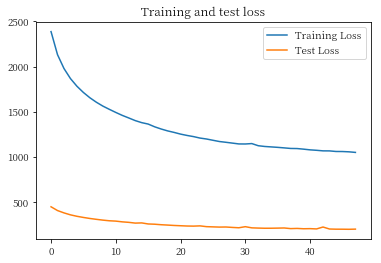

In [8]:
# evaluate the result
%matplotlib inline
epochs = range(EPOCH)

# plot training & validation accuracy per epoch
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Training and test loss')
plt.legend()
plt.show()

In [12]:
# generate a poem from the first sentence
def generate(model, start_char, poem_length, ix2word, word2ix, device):
    results = list(start_char)
    start_words_len = len(start_char)

    input_ = torch.Tensor([word2ix['<START>']]).view(1, 1).long().to(device)
    hidden = torch.zeros((2, NUM_LAYERS, 1, HIDDEN_SIZE),dtype=torch.float).to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i in range(poem_length):
            output, hidden = model(input_, hidden)
            if i < start_words_len:
                char = results[i]
                input_ = input_.data.new([word2ix[char]]).view(1, 1)
            else:
                top_index = output.data[0].topk(1)[1][0].item()
                char = ix2word[top_index]
                results.append(char)
                input_ = input_.data.new([top_index]).view(1, 1)
            if char == '<EOP>': 
                del results[-1]
                break
        return results

In [13]:
# generate a poem from the initial character of each sentence
def generate_initials(model, start_char, poem_style, ix2word, word2ix, device):
    results = []
    total_sentences = math.ceil(len(start_char)/2) * 2 # poems usually have even sentences
    poem_length = total_sentences * (poem_style+1)
    num_sentences = 0
    pre_char = '<START>'

    input_ = torch.Tensor([word2ix['<START>']]).view(1, 1).long().to(device)
    hidden = None
    model = model.to(device)
    model.eval()   
    
    with torch.no_grad():
        for i in range(poem_length):
            output, hidden = model(input_, hidden)
            top_index = output.data[0].topk(1)[1][0].item()
            char = ix2word[top_index]
            
            if pre_char in {'。', '，', '?', '！', '<START>'}:
                if num_sentences == total_sentences:
                    break
                elif num_sentences == len(start_char):
                    char = ix2word[top_index]
                    input_ = input_.data.new([top_index]).view(1, 1)
                    num_sentences += 1
                else:
                    char = start_char[num_sentences]
                    num_sentences += 1
                    input_ = input_.data.new([word2ix[char]]).view(1, 1)
            else:
                input_ = input_.data.new([top_index]).view(1, 1)
            results.append(char)
            pre_char = char
        return results

In [14]:
# model application
model.load_state_dict(torch.load('./model/LSTM_epoch40.pth'))

start_chars = '雁栖'
poem_length = 48
results = generate(model, start_chars, poem_length, ix2word, word2ix, device)
print(''.join(i for i in results))

initial_chars = '端午安康'
poem_style = 5
results = generate_initials(model, initial_chars, poem_style, ix2word, word2ix, device)
print(''.join(i for i in results))

雁栖有何人，时有平阳客。自古古来书，有诗多不饱。我生西之间，君子不相识。一见如来人，一日无所欲。
端拙须长叹，午年何所为。安贫即此路，康乐当及时。
